In [20]:
# Importing necessary libraries
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import resnet50

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Loading the dataset
dataset_dir = "/content/drive/MyDrive/IndianCurrencyNotesDataset/AllImages"

In [12]:
# Splitting the dataset into train/test
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 178 files belonging to 7 classes.
Using 143 files for training.
Found 178 files belonging to 7 classes.
Using 35 files for validation.


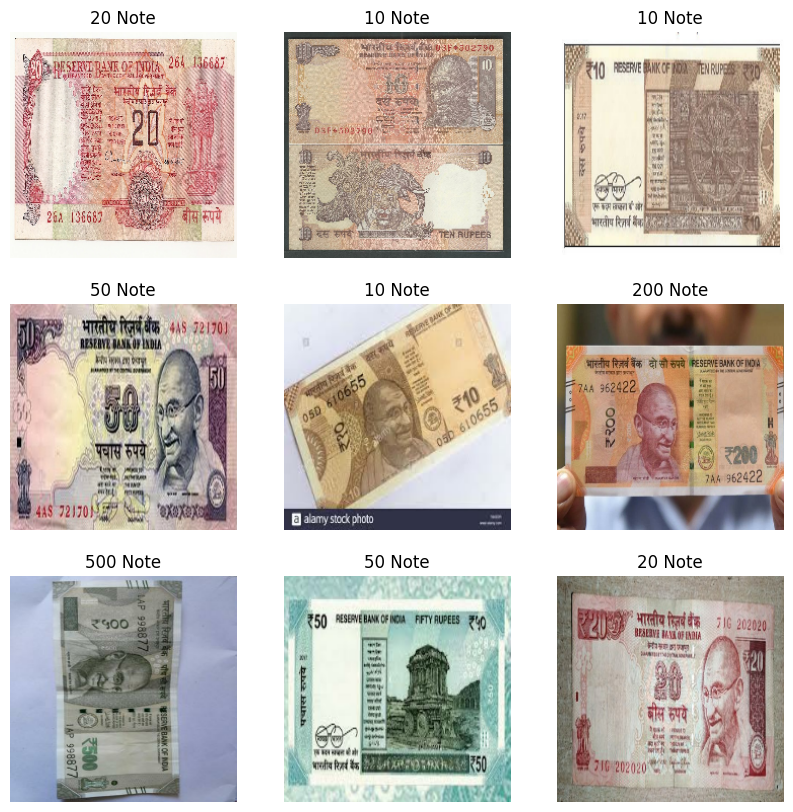

In [13]:
class_names = train_ds.class_names

# Data Augmentation (only on train data)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.Rescaling(1./255)
])

# Visualizing few training samples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [14]:
# Feature Extraction using pretrained ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
resnet_model.trainable = False

def extract_features(dataset):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        batch_images = preprocess_input(batch_images)
        batch_features = resnet_model(batch_images)
        features.append(batch_features.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_ds)
val_features, val_labels = extract_features(val_ds)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Training SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(train_features, train_labels)

SVC(kernel='linear')

In [16]:
# Predictions
val_preds = svm_clf.predict(val_features)

In [17]:
# Evaluation
acc = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.94
F1 Score: 0.94


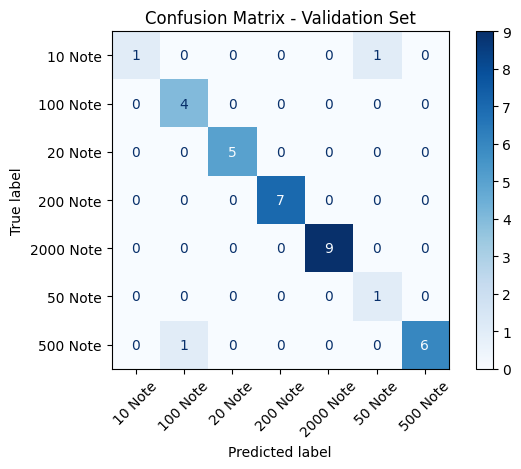

In [18]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - Validation Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


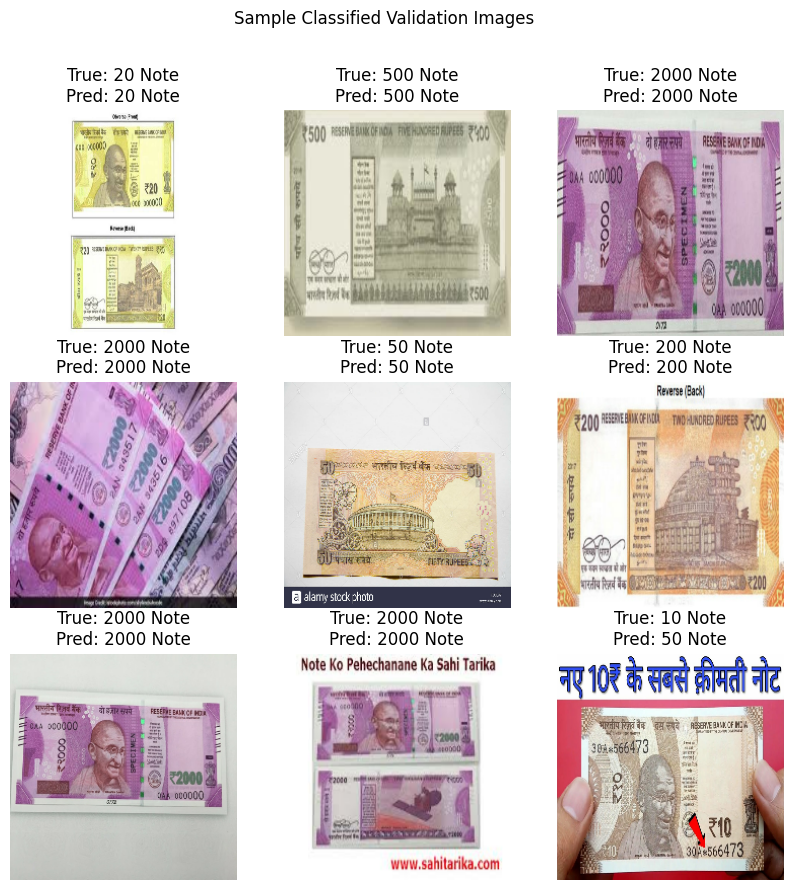

In [22]:
plt.figure(figsize=(10, 10))
shown = 0
# Process the first batch of images
for images, labels in val_ds.take(1):

    # Preprocessing the images for ResNet
    preprocessed = resnet50.preprocess_input(images)

    # Extracting features from the images using the ResNet model
    features = resnet_model.predict(preprocessed)

    # Making predictions using the SVM classifier
    preds = svm_clf.predict(features)

    # Displaying 9 images in a 3x3 grid
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
        shown += 1

plt.suptitle("Sample Classified Validation Images")
plt.show()


# **REPORT**

1. What were the main innovations in ResNet and GoogLeNet?

  Ans. ResNet: Allows skipping connections so the layers carrying irrelevant and unimportant information can be skipped. In layman terms, introduced residual blocks with skip connections to mitigate the problem of vanishing gradients.

  GoogLeNet: Higly complex architecture which utilised every possible connetion. Also, it used inception modules with multi-scale filters for efficient feature extraction.

2. Why do we at times need Transfer Learning?

 Ans. Transfer learning allows us to reuse pre-trained models on a similar problem that we are solving. We use transfer learning when we have smaller dataset (less amount of data) and we require the model to work well for it. In other words, Transfer learning allows leveraging pre-trained models on large datasets like ImageNet to achieve good performance on smaller datasets without extensive training. However, transfer learning can only work when the features extracted in the first problem are generalizable enough to be used in the second problem.

3. How can up sampling training set help with Transfer Learning?

 Ans. Up sampling or synthetically increasing the number of training samples (say through data augmentation technniques like rotation, scaling etc) can make the model learns more robust patterns, reducing overfitting and thereby improving overall model generalization.

4. Are there any limitations of using Transfer Learning? List only two.

 Ans. Limitations of Transfer Learning can be:

 (i) Transfer learning would fail if there's a domain mismatch between the two problems or between source and target data i.e it may not generalize well to a very different target domain.

 (ii) Overfitting may occur on small datasets


5. What are the different approaches in Transfer Learning?

 Ans. Different approaches in Transfer Learning are:

  (i) Approach 1: Freeze all but the last layer and replace it for our smaller dataset.

  (ii) Approach 2: Extract learned features from last but one layer and use any traditional ML approach (for e.g., SVM, KNN) for classification on our smaller dataset.

  (iii) Approach 3: Fine-tune a few layers of the network for our smaller dataset.